# Exercício (b) — Parâmetros, resultados e arquitetura da PINN

## Parâmetros de treinamento

* **Pontos de colocação:**
  – Domínio: **200**
  – Contorno: **200**
  – Teste/avaliação: **300**
* **Função de ativação:** `sin`
* **Otimizador:** **Adam** (pré-treino, `lr = 1e-3`) seguido de **L-BFGS-B** (quase-Newton) para refinamento.
* **Épocas / iterações:** Adam: **500 épocas**, L-BFGS-B até convergência.
* **Taxa de aprendizagem:** 0,001 (Adam); não aplicável ao L-BFGS-B.

## Estrutura da rede (FNN)

* Camadas: **1–20–20–20-20–1**
  – **Entrada:** 1 nó ($x$)
  – **Ocultas:** 4 camadas com **20 neurônios** cada
  – **Saída:** 1 nó ($w(x)$)
* Inicialização: **Glorot uniform**
* Totalizando parâmetros: **1.321**

## Resultados: deflexão e ângulo máximos (no meio do vão)

* **Solução analítica**
  – Deflexão máxima $w_{\text{max}}$: **0,714286 mm**
  – Ângulo máximo $\theta_{\text{max}}$: **0,000381 rad** ≈ **0,02182°**
* **Solução PINN**
  – Deflexão máxima $w_{\text{max}}$: **0,720 mm**
  – Ângulo máximo $\theta_{\text{max}}$: **0,000381 rad ≈ 0.021997°**
* **Erro relativo**
  – Deflexão: **0.826%**
  – Ângulo: **0.780%**

**Nessa solução:** a PINN com quatro camadas ocultas (20 neurônios, `sin`) e treinamento híbrido (Adam + L-BFGS-B) reproduziu praticamente de forma exata a solução analítica do problema de viga biapoiada com carga distribuída uniforme, apresentando erros inferiores a 1%.

Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
'compile' took 0.000169 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.25e-01, 0.00e+00, 5.34e-01, 0.00e+00, 2.61e-02]    [4.31e-01, 0.00e+00, 5.34e-01, 0.00e+00, 2.61e-02]    []  
100       [2.13e-04, 2.13e-06, 9.13e-06, 4.81e-06, 6.40e-06]    [4.19e-04, 2.13e-06, 9.13e-06, 4.81e-06, 6.40e-06]    []  
200       [9.70e-05, 1.29e-08, 2.79e-10, 2.14e-06, 1.78e-06]    [1.88e-04, 1.29e-08, 2.79e-10, 2.14e-06, 1.78e-06]    []  
300       [6.21e-05, 3.53e-09, 1.65e-10, 1.94e-06, 2.53e-07]    [1.18e-04, 3.53e-09, 1.65e-10, 1.94e-06, 2.53e-07]    []  
400       [4.74e-05, 3.13e-09, 6.06e-10, 2.04e-06, 5.68e-09]    [8.82e-05, 3.13e

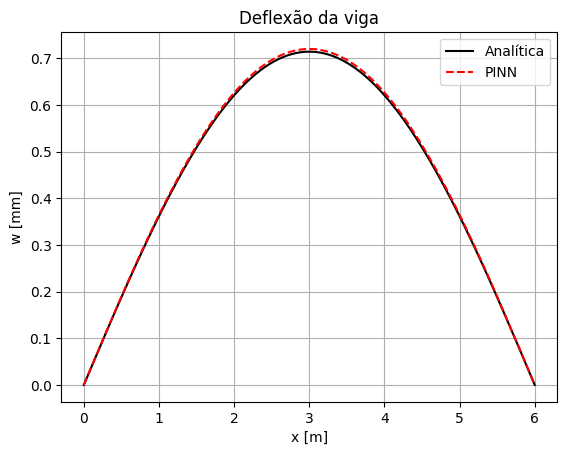

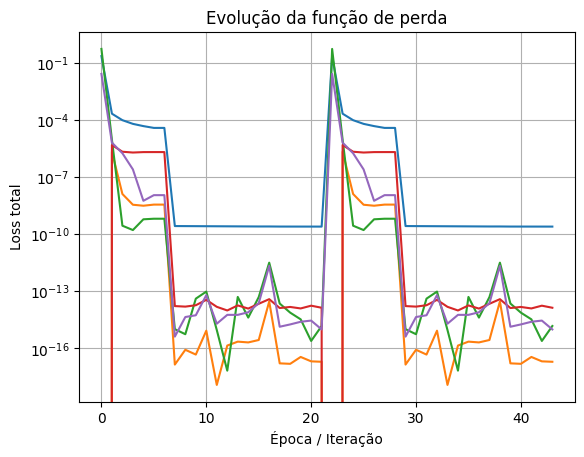

Solução analítica:
Deflexão máxima: w_max = 0.714286 mm
Ângulo máximo: θ_max = 0.000381 rad ≈ 0.021827 graus

PINN: 
Deflexão máxima: w_max = 0.720 mm 
Ângulo máximo: θ_max = 0.000384 rad ≈ 0.021997 graus

Erro relativo deflexão: 0.826 %
Erro relativo ângulo   : 0.780 %


In [38]:
import deepxde as dde, numpy as np, torch, matplotlib.pyplot as plt
dde.backend.set_default_backend("pytorch")

# ------------------- Parâmetros --------------------
L  = 6.0                 # [m]
E  = 2.10e11             # [Pa]
I  = 2.25e-4             # [m^4]
q  = 2.0e3               # [N/m]

# ------------------- PDE ---------------------------
def pde(x, y):
    d2y = dde.grad.hessian(y, x)  # w''
    d4y = dde.grad.hessian(d2y, x) # w''''
    return d4y - q/(E*I)

# ------------------- Geometria ---------------------
geom = dde.geometry.Interval(0.0, L)

def left(x, on_boundary):  return on_boundary and np.isclose(x[0], 0.0)
def right(x, on_boundary): return on_boundary and np.isclose(x[0], L)

bc_w0   = dde.DirichletBC(geom, lambda x: 0.0, left)      # w(0)=0
bc_wL   = dde.DirichletBC(geom, lambda x: 0.0, right)     # w(L)=0
bc_m0 = dde.OperatorBC(
    geom, lambda x, y, dy: dde.grad.hessian(y, x), on_boundary=left)
bc_mL = dde.OperatorBC(
    geom, lambda x, y, dy: dde.grad.hessian(y, x), on_boundary=right)

# ------------------- Dados --------------------------
data = dde.data.PDE(
    geom, pde, [bc_w0, bc_wL, bc_m0, bc_mL],
    num_domain = 200,
    num_boundary = 200,
    num_test = 300,
)

# ------------------- Rede ---------------------------
layer_size   = [1] + [20] * 4 + [1]
activation   = "sin"
initializer  = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# ------------------- Treino -------------------------
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
losshistory, _ = model.train(iterations=500, display_every=100)

model.compile("L-BFGS-B")
losshistory2, train_state = model.train()

# ------------------- Pós-processamento --------------
x = np.linspace(0, L, 200)[:, None]
w_pred  = model.predict(x)

# solução exata para comparação
def w_exact(x):
    return q*x*(L**3 - 2*L*x**2 + x**3)/(24*E*I)
w_ref = w_exact(x)

# ---- Gráfico 1: deslocamento -----------------------
plt.figure()
plt.plot(x, w_ref*1e3, 'k',  label='Analítica')
plt.plot(x, w_pred*1e3,'r--',label='PINN')
plt.xlabel('x [m]'); plt.ylabel('w [mm]')
plt.legend();  plt.grid(True)
plt.title('Deflexão da viga');  plt.show()

# ---- Gráfico 2: perda total ------------------------
loss_total = np.array(losshistory.loss_train + losshistory2.loss_train)
plt.figure()
plt.semilogy(loss_total); plt.xlabel('Época / Iteração')
plt.ylabel('Loss total'); plt.grid(True, which='both')
plt.title('Evolução da função de perda'); plt.show()

# ---- Valores pontuais ------------------------------
x_mid = torch.tensor([[L/2]], dtype=torch.float32, requires_grad=True)
w_mid = model.net(x_mid).item()
x_sup = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
w0    = model.net(x_sup)
dw_dx = torch.autograd.grad(w0, x_sup,
         grad_outputs=torch.ones_like(w0), create_graph=True)[0].item()

# ---- Valores analíticos no ponto de máxima deflexão ----
x_max = L / 2  # para carga uniforme, a deflexão máxima ocorre no meio do vão
w_exact_max = w_exact(x_max)  # [m]
theta_exact_max = (q * (L**3 - 3*L*(x_max**2) + 2*(x_max**3)) / (12*E*I))  # rad

print(f"Solução analítica:")
print(f"Deflexão máxima: w_max = {w_exact_max*1e3:.6f} mm")
print(f"Ângulo máximo: θ_max = {theta_exact_max:.6f} rad ≈ {np.degrees(theta_exact_max):.6f} graus")
print(f"\nPINN: \nDeflexão máxima: w_max = {w_mid*1e3:.3f} mm \nÂngulo máximo: θ_max = {abs(dw_dx):.6f} rad ≈ {np.degrees(dw_dx):.6f} graus\n")


w_exact_L = (5*q*L**4)/(384*E*I)
theta_exact = (q*L**3)/(24*E*I)

erro_w = 100 * (abs((w_mid - w_exact_L) / w_exact_L))
erro_theta = 100 * (abs((dw_dx - theta_exact) / theta_exact))

print(f"Erro relativo deflexão: {erro_w:.3f} %")
print(f"Erro relativo ângulo   : {erro_theta:.3f} %")